In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
% matplotlib inline

Read autos.csv into data, and display sample.

In [ ]:
data=pd.read_csv('../input/autos.csv', encoding='latin_1')
data.head()

Let's check for null values in rows.

In [3]:
data.isnull().sum()

dateCrawled                0
name                       0
seller                     0
offerType                  0
price                      0
abtest                     0
vehicleType            37869
yearOfRegistration         0
gearbox                20209
powerPS                    0
model                  20484
kilometer                  0
monthOfRegistration        0
fuelType               33386
brand                      0
notRepairedDamage      72060
dateCreated                0
nrOfPictures               0
postalCode                 0
lastSeen                   0
dtype: int64

In [4]:
data['vehicleType'].fillna('none', inplace=True)
data['model'].fillna('none', inplace=True)
data['gearbox'].fillna('none',inplace=True)
data['fuelType'].fillna('none',inplace=True)
data['notRepairedDamage'].fillna('none',inplace=True)

In [5]:
usedcars = data[(data.vehicleType != 'none') & (data.vehicleType != 'andere')]
usedcars = usedcars[(usedcars.price >= 100) & (usedcars.price <=160000) & (usedcars.yearOfRegistration >=1950) & (usedcars.yearOfRegistration <=2016) & (usedcars.powerPS >=10) & (usedcars.powerPS<=500)]
# if these strings are found in the name of an ad, set them as brands
brands = ['Lexus', 'Ferrari', 'Dodge', 'Cadillac', 'MG', 'Lotus', 'Iveco', 'Ssangyong', 'Pontiac', 'Wartburg']

for b in brands:
    usedcars.loc[(usedcars.brand == 'sonstige_autos') & (usedcars.name.str.contains(b, case='False')), 'brand'] = b.lower()

usedcars = usedcars[(usedcars.brand != 'sonstige_autos') & (usedcars.model != 'none')]

In [6]:
# since data set is taken in 2016 set this year as current when calculating depriciation
current_year = 2016

newcars = usedcars[(usedcars.kilometer <= 10000) & (usedcars.yearOfRegistration == current_year) & (usedcars.powerPS > 0) & (usedcars.fuelType != 'none') & (usedcars.notRepairedDamage != 'ja') & (usedcars.vehicleType != 'none') & (usedcars.gearbox != 'none') & (usedcars.price >= 5000)]
newcars.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
1254,2016-04-03 10:51:38,Peugeot_Partner_Tepee_BlueHDi_100_Stop&Start_E...,privat,Angebot,17800,control,bus,2016,manuell,99,andere,5000,1,diesel,peugeot,nein,2016-04-03 00:00:00,0,10551,2016-04-07 11:46:25
2080,2016-03-19 17:43:51,Nissan_Micra_1.2_Acenta,privat,Angebot,10490,control,kleinwagen,2016,manuell,80,micra,5000,3,benzin,nissan,nein,2016-03-19 00:00:00,0,41334,2016-03-30 13:16:59
3443,2016-04-05 10:49:54,Land_Rover_Defender_90_DPF_Station_Wagon_Heritage,privat,Angebot,59900,control,suv,2016,manuell,122,defender,5000,2,diesel,land_rover,nein,2016-04-05 00:00:00,0,21220,2016-04-07 14:56:12
3966,2016-04-04 22:42:14,Mazda_MX_5_SKYACTIV_G_160_i_ELOOP_Sports_Line,privat,Angebot,27000,test,cabrio,2016,manuell,160,mx_reihe,5000,2,benzin,mazda,nein,2016-04-04 00:00:00,0,29471,2016-04-07 01:16:37
6888,2016-04-01 16:39:10,Volkswagen_Golf_GTD_DSG_Kamera+Panorama+Fahras...,privat,Angebot,29950,control,limousine,2016,automatik,184,golf,5000,2,diesel,volkswagen,nein,2016-04-01 00:00:00,0,64380,2016-04-05 11:18:49


Lets determine the prices of new vehicles. If price of new car for type and brand of a vehicle are available, average over that data. If no such data is available, average over all brands.

In [47]:
import math

# dataset is created in 2016
current_year = 2016

# calculate average price of a new car by vehicle type
def price_by_vehicle_type(c):
    return {t: np.mean(c[(c.vehicleType == t) & (c.yearOfRegistration == current_year)].price) for t in c.vehicleType.unique()}

# calculate average price of a new car by vehicle type and brand
def price_by_vehicle_type_and_brand(c):
    d = {}
    for t in c.vehicleType.unique():
        for b in c[c.vehicleType == t].brand.unique():
            if c[(c.vehicleType == t) & (c.yearOfRegistration == current_year) & (c.brand == b)].shape[0] > 0:
                d[(t, b)] = np.mean(c[(c.vehicleType == t) & (c.yearOfRegistration == current_year) & (c.brand == b)].price)
    return d       

price_vt = price_by_vehicle_type(newcars)
price_vt_b = price_by_vehicle_type_and_brand(newcars)

# try to find average price of a new car by its type and brand
# if there is no such data find average price of this type of a car
def price_of_new_car(vehicle_type, brand):
    if (vehicle_type, brand) in price_vt_b:
        return price_vt_b[(vehicle_type, brand)]
    return price_vt[vehicle_type]


def depreciation(years, depr_dict):
    return depr_dict[years]

# benchmark based on vehicle type, brand, year of registration and depriciation schedule
def evaluate(vehicle_type, brand, registration_year, depreciation_dict):
    return price_of_new_car(vehicle_type, brand)*depreciation(current_year - registration_year, depreciation_dict)
    

Lets display some of the new car prices by type.

In [41]:
dataFrame_C = pd.DataFrame.from_dict(price_vt, orient="index")
dataFrame_C.columns = ['New car price']
dataFrame_C.head(10)

,New car price
coupe,58755.000000
bus,34844.259259
cabrio,62893.875000
kleinwagen,14880.139241
suv,41128.600000
limousine,28727.641509
kombi,31448.724138


Lets display some of the new car prices by type and brand.

In [9]:
dataFrame_C = pd.DataFrame.from_dict(price_vt_b, orient="index")
dataFrame_C.columns = ['New car price']
dataFrame_C.head()

,New car price
"(limousine, bmw)",39168.000000
"(coupe, audi)",43000.000000
"(limousine, opel)",12499.000000
"(kombi, dacia)",13000.000000
"(suv, nissan)",27888.666667


This cell creates dictionary that maps years of usage to depreciations given depreciation rate 

In [65]:
rate = 0.18
depr_dict = {i: math.pow(1.0-rate, i) for i in range(0,100,1)}

This cell creates dictinary that maps years of usage to average depreciation, calculated from data.

In [68]:
# calculate depriciation given years since registration
def avg_depreciation(years):
    year2cars = usedcars[usedcars.yearOfRegistration == current_year-years]
    return np.mean([year2cars.loc[i].price/price_of_new_car(year2cars.loc[i]['vehicleType'], year2cars.loc[i]['brand']) for i in year2cars.index.values])

avg_depriciation_dict = {i : avg_depreciation(i) for i in range(1,21,1)}
for i in range(0,100,1):
    if i not in avg_depriciation_dict:
        avg_depriciation_dict[i] = math.pow(1-0.15, i)
depr_dict = avg_depriciation_dict

And finally, lets calculate absolute and square root error for usedcars.

In [69]:
abs_error = [math.fabs(evaluate(usedcars.loc[i]['vehicleType'], usedcars.loc[i]['brand'], usedcars.loc[i]['yearOfRegistration'], depr_dict) - usedcars.loc[i]['price'])  for i in usedcars.index.values]
abs_per_error = [math.fabs(evaluate(usedcars.loc[i]['vehicleType'], usedcars.loc[i]['brand'], usedcars.loc[i]['yearOfRegistration'], depr_dict) - usedcars.loc[i]['price'])/usedcars.loc[i]['price']  for i in usedcars.index.values]
sqr_error = [math.pow(evaluate(usedcars.loc[i]['vehicleType'], usedcars.loc[i]['brand'], usedcars.loc[i]['yearOfRegistration'], depr_dict) - usedcars.loc[i]['price'], 2)  for i in usedcars.index.values]
print ("Square error: %.2f" % np.sqrt(np.mean(sqr_error)))
print ("Absolute error: %.2f" % np.mean(abs_error))
print ("Percentage error: %.2f" % (np.mean(abs_per_error)*100))

Square error: 5723.83
Absolute error: 2891.77
Percentage error: 75.20


Let's display some cars and their estimated prices.

In [27]:
ind = usedcars.index.values[116]
print ("New car price: %.2f" % price_of_new_car(usedcars.loc[ind].vehicleType, usedcars.loc[ind].brand))
print ("Depreciation %.2f" % (depreciation(current_year - usedcars.loc[ind].yearOfRegistration)*100), "%")
print ("Price :", usedcars.loc[ind].price)
print ("Evaluation :", evaluate(usedcars.loc[ind].vehicleType, usedcars.loc[ind].brand ,usedcars.loc[ind].yearOfRegistration))
usedcars.loc[ind]

New car price: 14880.14
depreciation 10.94 %
Price : 1499
Evaluation : 1627.55908472


dateCrawled                                        2016-03-08 19:58:07
name                   A_210_Evolution_AMG_Styling_absoluter_Festpreis
seller                                                          privat
offerType                                                      Angebot
price                                                             1499
abtest                                                            test
vehicleType                                                 kleinwagen
yearOfRegistration                                                2002
gearbox                                                        manuell
powerPS                                                            140
model                                                         a_klasse
kilometer                                                       150000
monthOfRegistration                                                 10
fuelType                                                          none
brand 

Average depreciation of used cars by year

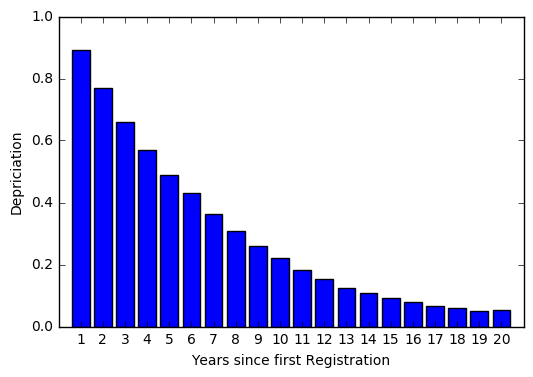

In [36]:
plt.bar(range(len(depreciation_dict)), depreciation_dict.values(), align='center')
plt.xticks(range(len(depreciation_dict)), list(depreciation_dict.keys()))
plt.ylim(0.0, 1.0)
plt.xlim(-1, 20)
plt.ylabel("Depriciation")
plt.xlabel("Years since first Registration")
plt.show()

In [70]:
print ("There are ", newcars.shape[0], " new cars in the data set")

There are  272  new cars in the data set
